--- 1. Data Loading and Initial EDA ---
Dataset shape: (100, 13)
  Loan_ID  Gender Married Dependents     Education Self_Employed  \
0   LP001    Male     Yes          0      Graduate            No   
1   LP002  Female      No          1  Not Graduate           Yes   
2   LP003    Male     Yes          2      Graduate            No   
3   LP004     NaN      No         3+  Not Graduate            No   
4   LP005  Female     Yes        nan      Graduate           NaN   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5000               1000       120.0               360   
1             4500                  0       150.0               180   
2             6000               2000         NaN               360   
3             3500               1500       100.0               360   
4             7000                500       200.0               360   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1      

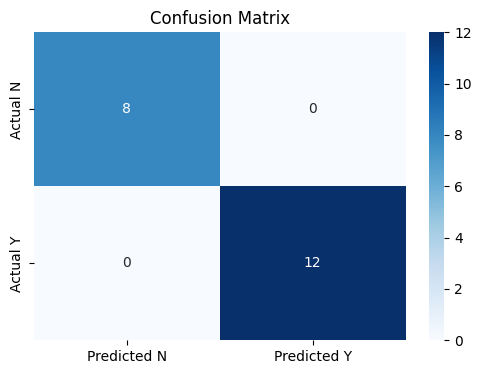

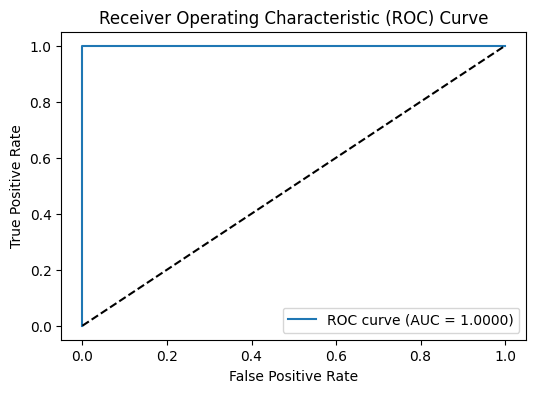

--------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv(r'/content/loan_approval_dataset.csv')

data = {
    'Loan_ID': [f'LP00{i}' for i in range(1, 101)],
    'Gender': ['Male', 'Female', 'Male', np.nan, 'Female'] * 20,
    'Married': ['Yes', 'No', 'Yes', 'No', 'Yes'] * 20,
    'Dependents': [0, 1, 2, '3+', np.nan] * 20,
    'Education': ['Graduate', 'Not Graduate'] * 50,
    'Self_Employed': ['No', 'Yes', 'No', 'No', np.nan] * 20,
    'ApplicantIncome': [5000, 4500, 6000, 3500, 7000] * 20,
    'CoapplicantIncome': [1000, 0, 2000, 1500, 500] * 20,
    'LoanAmount': [120, 150, np.nan, 100, 200] * 20,
    'Loan_Amount_Term': [360, 180, 360, 360, 360] * 20,
    'Credit_History': [1.0, 0.0, 1.0, np.nan, 0.0] * 20,
    'Property_Area': ['Urban', 'Semiurban', 'Rural', 'Urban', 'Semiurban'] * 20,
    'Loan_Status': ['Y', 'N', 'Y', 'Y', 'N'] * 20  # TARGET
}
df = pd.DataFrame(data)

# Convert Dependents to string type for consistency with real-world data
df['Dependents'] = df['Dependents'].astype(str)

print("--- 1. Data Loading and Initial EDA ---")
print(f"Dataset shape: {df.shape}")
print(df.head())
print("-" * 50)
# -----------------------------------------------------------------------


# --- 2. DATA PREPROCESSING PIPELINE (Feature Engineer's Role) ---

# Define target variable and features
X = df.drop(['Loan_Status', 'Loan_ID'], axis=1)
y = df['Loan_Status']

# Encode the target variable: Y -> 1, N -> 0
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Identify column types
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Define Preprocessing Pipelines
# Pipeline for numerical features: Impute with median, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: Impute with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Create a Column Transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Preprocessing pipelines defined. Ready for Model Training.")
print("-" * 50)
# -----------------------------------------------------------------------


# --- 3. MODEL DEVELOPMENT & TUNING (Model Specialist's Role) ---

print("--- 3. Model Development and Hyperparameter Tuning ---")

# Create the full pipeline: Preprocessor + Model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}

# Use GridSearchCV for exhaustive search and Cross-Validation
# We use 'roc_auc' as the scoring metric as it's better for imbalanced classification
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest Cross-Validation ROC-AUC Score: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")
print("-" * 50)
# -----------------------------------------------------------------------


# --- 4. EVALUATION & REPORTING (Evaluation Specialist's Role) ---

print("--- 4. Final Model Evaluation ---")

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1] # Probability of approval (class 1)

# A. Key Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_prob)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Rejected (N)', 'Approved (Y)']))

# B. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted N', 'Predicted Y'],
            yticklabels=['Actual N', 'Actual Y'])
plt.title('Confusion Matrix')
plt.show() #

# C. ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {test_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show() #

print("-" * 50)
# -----------------------------------------------------------------------